In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [75]:
os.chdir('/Users/alexanderhepburn/Documents/MSc Data Science/1 DS Fundamentals/Assignment 2')

# Feature Engineering

In [76]:
attributes = pd.read_csv('data/attributes.csv', index_col=0)
edges = pd.read_csv('data/edges_train.edgelist', names=['node1', 'node2'])

In [77]:
G = nx.Graph()
G.add_edges_from(edges.values)

In [78]:
print(G)

Graph with 1500 nodes and 6600 edges


Encode 'attributes'

In [79]:
le = LabelEncoder()
attributes['encoded_attr'] = le.fit_transform(attributes['attribute'])

In [80]:
#dummies = pd.get_dummies(attributes.attribute)
#attributes = pd.concat([dummies])
#attributes.drop(attributes.columns[0], axis=1, inplace=True)

In [81]:
attributes

,attribute,encoded_attr
ID,,
0,l,2
1,x,4
2,x,4
3,x,4
4,x,4
...,...,...
1495,l,2
1496,l,2
1497,l,2


This function calculates several features based on each pair of nodes within the network.

In [82]:
def extract_features(node1, node2, G):
    features = []
    # Common neighbors
    #common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))
    #features.append(common_neighbors)
    
#Jaccard Coefficient
    jaccard_coeff = list(nx.jaccard_coefficient(G, [(node1, node2)]))[0][2]
    features.append(jaccard_coeff)
    
    # Preferential Attachment
    pref_attach = list(nx.preferential_attachment(G, [(node1, node2)]))[0][2]
    features.append(pref_attach)
    
    # Adamic-Adar Index
    adamic_adar = list(nx.adamic_adar_index(G, [(node1, node2)]))[0][2]
    features.append(adamic_adar)
    
    # Shortest Path Distance (if reachable)
    try:
        shortest_path = nx.shortest_path_length(G, source=node1, target=node2)
    except nx.NetworkXNoPath:
        shortest_path = -1
    features.append(shortest_path)
    
    # Node attributes (encoded)
    attr_diff = abs(attributes.loc[node1, 'encoded_attr'] - attributes.loc[node2, 'encoded_attr'])
    features.append(attr_diff)
    
    return features


Using 'extract_features' we can now construct our final X and Y sets.

In [83]:
def create_dataset(G, edges, attributes):
    X = []
    y = []
    
    # Positive samples (existing edges)
    for i, row in edges.iterrows():
        node1, node2 = row['node1'], row['node2']
        X.append(extract_features(node1, node2, G))
        y.append(1)  # Positive label
    
    # Negative samples (non-existing edges)
    non_edges = []
    while len(non_edges) < len(edges):
        node1, node2 = np.random.randint(0, len(attributes), 2)
        if not G.has_edge(node1, node2) and node1 != node2:
            X.append(extract_features(node1, node2, G))
            y.append(0)  # Negative label
            non_edges.append((node1, node2))
    
    return np.array(X), np.array(y)


In [84]:
X, y = create_dataset(G, edges, attributes)

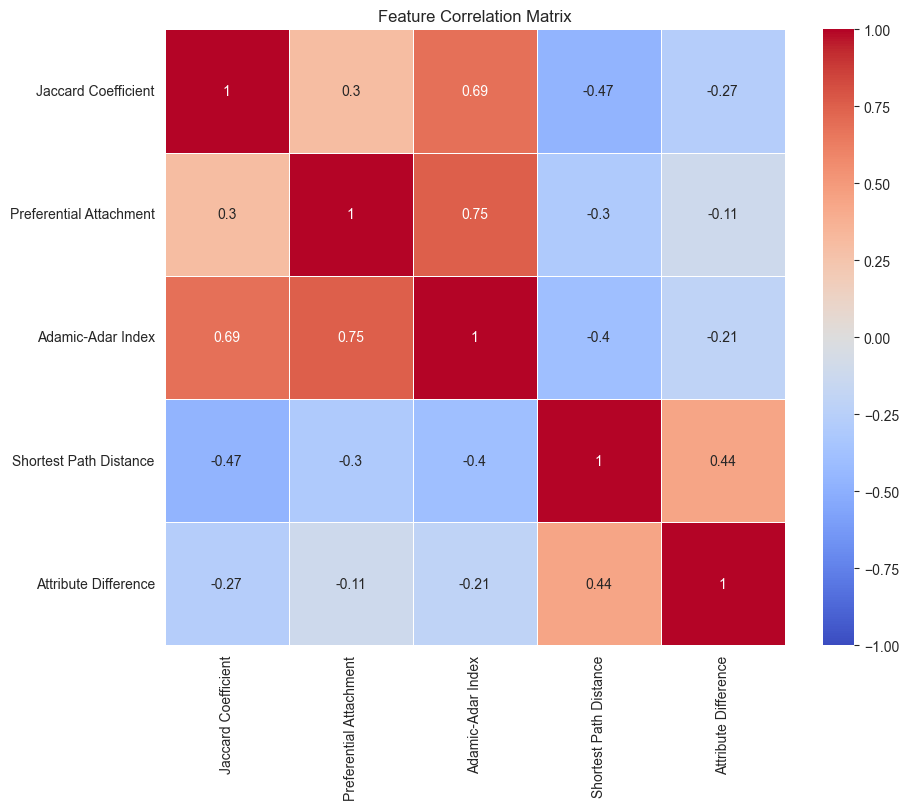

In [86]:
# Convert X_raw to a DataFrame for better visualization
feature_names = [
    # "Common neighbors",
    "Jaccard Coefficient",
    "Preferential Attachment",
    "Adamic-Adar Index",
    "Shortest Path Distance",
    "Attribute Difference"
]
X_df = pd.DataFrame(X, columns=feature_names)

# Step 2: Calculate the correlation matrix
corr_matrix = X_df.corr()

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

Based on the collinearity matrix I removed the 'common neighbours' feature.

PICK ONE PREPROCESSING BRANCH

### Branch 1: PCA

Principal Component Analysis

In [103]:
X, y = create_dataset(G, edges, attributes)

# After feature extraction, but before model training:
from sklearn.decomposition import PCA

# Assume X is the feature matrix and y is the label vector from create_dataset function

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # You can change the number of components
X_pca = pca.fit_transform(X)

# Now X_pca is the reduced feature set, and we proceed with training
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


### Branch 2: NO PCA

In [87]:
X, y = create_dataset(G, edges, attributes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

In [88]:
#X_train

array([[2.94117647e-02, 3.06000000e+02, 3.06927676e-01, 1.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 4.00000000e+01, 0.00000000e+00, 1.00000000e+00,
        4.00000000e+00],
       [1.25000000e-01, 8.36000000e+02, 2.71600827e+00, 1.00000000e+00,
        1.00000000e+00],
       ...,
       [0.00000000e+00, 4.00000000e+01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 6.00000000e+01, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [0.00000000e+00, 2.40000000e+01, 0.00000000e+00, 5.00000000e+00,
        1.00000000e+00]])

# Modelling

I did logreg and random forest for now. Both performed oddly well.... Could they possibly be overfitting?


In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [105]:
kf = KFold(n_splits=10, shuffle=True, random_state= 55)

### Logistic Regression

In [106]:
clf = LogisticRegression(random_state=42, C=0.001, max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=kf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.96 accuracy with a standard deviation of 0.01


In [107]:
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [10, 100, 1000]
}

In [108]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")


/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best Parameters: {'C': 0.1, 'max_iter': 100}
Best Cross-Validation Score: 1.0000


In [109]:
# Retrain the model with the best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Evaluate on the held-out test set again
y_pred_best = best_clf.predict(X_test)
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))
print("Classification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))

Accuracy with Best Parameters: 1.0
Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1320
           1       1.00      1.00      1.00      1320

    accuracy                           1.00      2640
   macro avg       1.00      1.00      1.00      2640
weighted avg       1.00      1.00      1.00      2640


CM Logreg

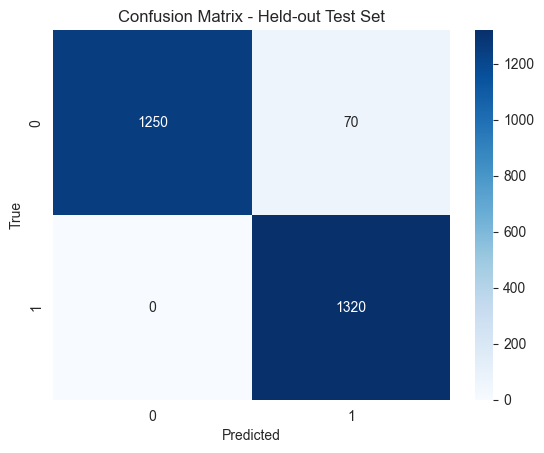

In [110]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest

Baseline model

In [112]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9765151515151516
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1320
           1       0.98      0.97      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Grid Search

In [113]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [114]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 1.0000


In [115]:
# Retrain the model with the best parameters
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

# Evaluate on the held-out test set again
y_pred_best = best_clf.predict(X_test)
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))
print("Classification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))

Accuracy with Best Parameters: 0.9988636363636364
Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1320
           1       1.00      1.00      1.00      1320

    accuracy                           1.00      2640
   macro avg       1.00      1.00      1.00      2640
weighted avg       1.00      1.00      1.00      2640


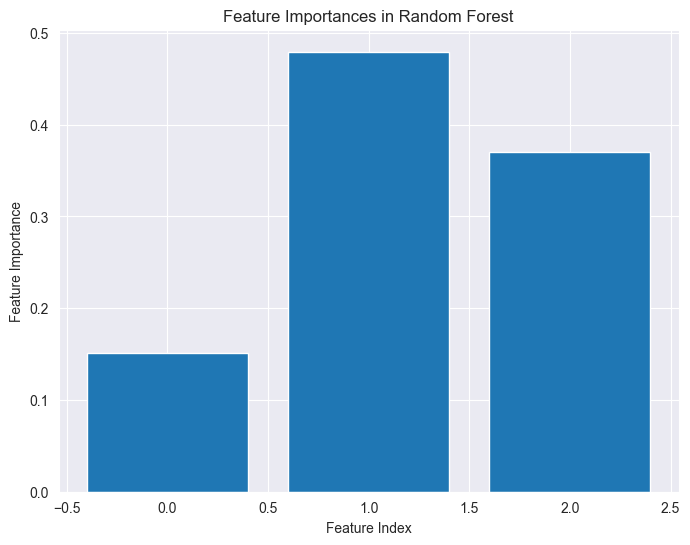

In [116]:
importances = clf.feature_importances_
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances in Random Forest')
plt.show()

CM Random forest

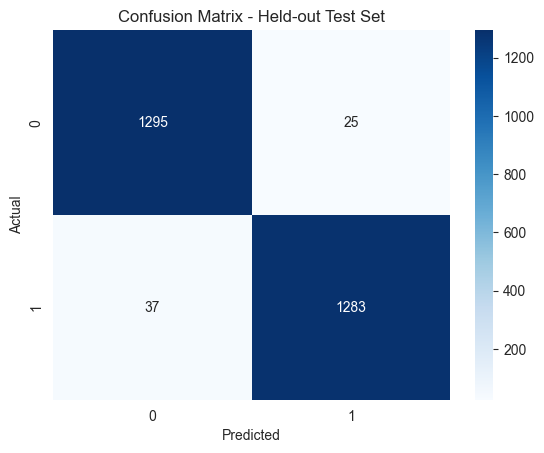

In [117]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()